In [1]:
!pip install tensorflow opencv-python matplotlib

  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 904.6 kB/s eta 0:00:00a 0:00:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.3 MB/s eta 0:00:0000:01
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using ca

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/1e6882e8-b10d-11ee-b2eb-ea94dbdc9feb.jpg'

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    
    height, width = frame.shape[:2]

    # Calculate the center of the frame
    center_x, center_y = width // 2, height // 2

    # Calculate the starting points for the 250x250 crop
    start_x = center_x - 125
    start_y = center_y - 125

    # Ensure the starting points do not go out of frame boundaries
    start_x = max(start_x, 0)
    start_y = max(start_y, 0)

    # Cut down frame to 250x250px centered
    frame = frame[start_y:start_y+250, start_x:start_x+250]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(0) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

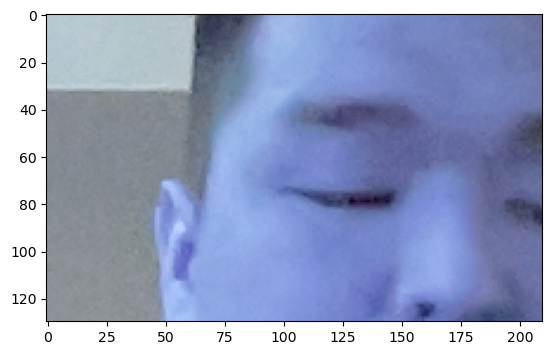

In [10]:
plt.imshow(frame[120:120+250,40:40+250, :])

In [11]:
def data_aug(img):
    data = []
    for i in range(9):
        temp_img = tf.identity(img)  # Create a copy of the image for this iteration

        # Generate seeds using TensorFlow
        seed1 = tf.random.uniform(shape=[], minval=0, maxval=100, dtype=tf.int32)
        seed2 = tf.random.uniform(shape=[], minval=0, maxval=100, dtype=tf.int32)

        # Apply different augmentations
        temp_img = tf.image.stateless_random_brightness(temp_img, max_delta=0.02, seed=(seed1, seed2))
        temp_img = tf.image.stateless_random_contrast(temp_img, lower=0.6, upper=1, seed=(seed1, seed2))

        seed1 = tf.random.uniform(shape=[], minval=0, maxval=100, dtype=tf.int32)
        seed2 = tf.random.uniform(shape=[], minval=0, maxval=100, dtype=tf.int32)

        temp_img = tf.image.stateless_random_flip_left_right(temp_img, seed=(seed1, seed2))
        temp_img = tf.image.stateless_random_jpeg_quality(temp_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(seed1, seed2))
        temp_img = tf.image.stateless_random_saturation(temp_img, lower=0.9, upper=1, seed=(seed1, seed2))
        
        data.append(temp_img)
    
    return data

In [12]:
import os
import uuid

In [14]:
img_path = os.path.join(ANC_PATH, '6527ebc6-a355-11ee-8a54-ea94dbdc9feb.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

[ WARN:0@1839.762] global loadsave.cpp:248 findDecoder imread_('data/anchor/6527ebc6-a355-11ee-8a54-ea94dbdc9feb.jpg'): can't open/read file: check file path/integrity


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [15]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

InvalidArgumentError: {{function_node __wrapped__StatelessRandomUniformIntV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} minval must be 0-D, got shape [2] [Op:StatelessRandomUniformIntV2] name: 

In [16]:
# Replace backslashes with forward slashes outside the f-string
anc_path_corrected = ANC_PATH.replace("\\", "/")
pos_path_corrected = POS_PATH.replace("\\", "/")
neg_path_corrected = NEG_PATH.replace("\\", "/")

# Use the corrected paths in the f-strings
anchor = tf.data.Dataset.list_files(f'{anc_path_corrected}/*.jpg').take(300)
positive = tf.data.Dataset.list_files(f'{pos_path_corrected}/*.jpg').take(250)
negative = tf.data.Dataset.list_files(f'{neg_path_corrected}/*.jpg').take(300)


In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data/anchor/e3f659a4-b10d-11ee-b2eb-ea94dbdc9feb.jpg'


In [19]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [20]:
img = preprocess('data/anchor/96822d08-a355-11ee-8a54-ea94dbdc9feb.jpg')

2024-01-12 12:11:16.331525: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/anchor/96822d08-a355-11ee-8a54-ea94dbdc9feb.jpg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} data/anchor/96822d08-a355-11ee-8a54-ea94dbdc9feb.jpg; No such file or directory [Op:ReadFile]

In [21]:
img.numpy().max() 

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [22]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [23]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
exampple = samples.next()

In [26]:
exampple

(b'data/anchor/ca06bc46-b10d-11ee-b2eb-ea94dbdc9feb.jpg',
 b'data/positive/c344cb2c-b10e-11ee-b2eb-ea94dbdc9feb.jpg',
 1.0)

In [27]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [28]:
res = preprocess_twin(*exampple)

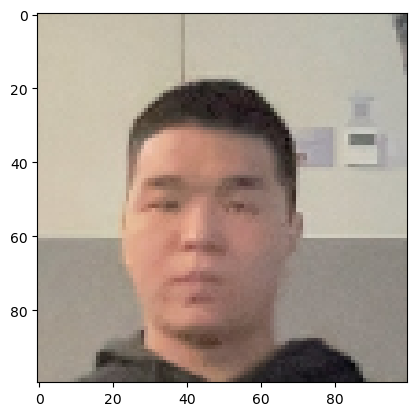

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [32]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [34]:
inp = Input(shape=(100,100,3), name='input_image')

In [35]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [36]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [45]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()


In [47]:
l1(anchor_embedding, validation_embedding)


NameError: name 'anchor_embedding' is not defined

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
siamese_layer = L1Dist()


In [51]:
distances = siamese_layer(inp_embedding, val_embedding)


In [52]:
classifier = Dense(1, activation='sigmoid')(distances)

In [53]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [54]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [55]:
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [56]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [57]:
siamese_model = make_siamese_model()


In [58]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [59]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [60]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001


In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [62]:
test_batch = train_data.as_numpy_iterator()


In [63]:
batch_1 = test_batch.next()


In [64]:
X = batch_1[:2]


In [65]:
y = batch_1[2]


In [66]:
y

array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [67]:
tf.losses.BinaryCrossentropy??


Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.ke

In [68]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [69]:
from tensorflow.keras.metrics import Precision, Recall


In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [71]:
EPOCHS = 50


In [72]:
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2024-01-12 12:12:16.222690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-12 12:12:16.264879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


25/25 [==============================] - 59s 2s/step
0.7590185 0.20231214 1.0

 Epoch 2/50
25/25 [==============================] - 57s 2s/step
0.34773847 0.70481926 1.0

 Epoch 3/50
25/25 [==============================] - 57s 2s/step
0.004518929 0.95977014 0.9823529

 Epoch 4/50
25/25 [==============================] - 57s 2s/step
0.00084841467 0.978022 1.0

 Epoch 5/50
25/25 [==============================] - 57s 2s/step
6.7353476e-06 0.98895025 0.99444443

 Epoch 6/50
25/25 [==============================] - 57s 2s/step
2.5034264e-05 0.9831461 1.0

 Epoch 7/50
25/25 [==============================] - 57s 2s/step
2.384186e-07 1.0 1.0

 Epoch 8/50
25/25 [==============================] - 57s 2s/step
-0.0 1.0 1.0

 Epoch 9/50
25/25 [==============================] - 57s 2s/step
2.2292386e-05 1.0 1.0

 Epoch 10/50
25/25 [==============================] - 57s 2s/step
0.014793201 0.99441344 1.0

 Epoch 11/50
25/25 [==============================] - 57s 2s/step
0.00015218224 0.98245615 1.

In [73]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [74]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [1]:
y_hat = siamese_model.predict([test_input, test_val])


NameError: name 'siamese_model' is not defined

In [76]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]

In [77]:
y_true


array([1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [78]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [79]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

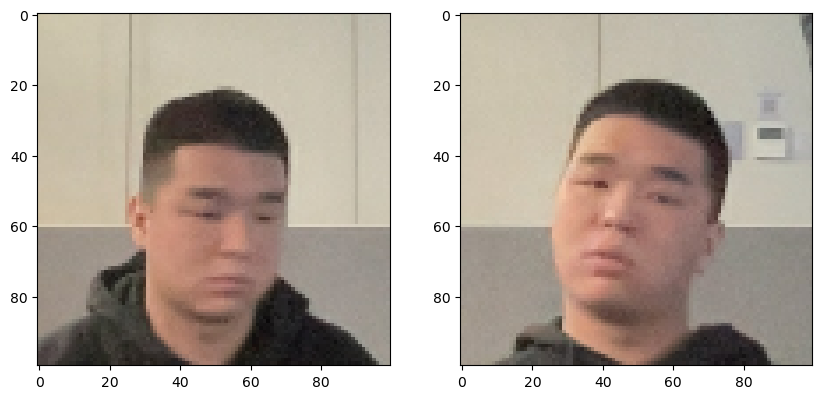

In [80]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [81]:
siamese_model.save('siamesemodelv2.h5')

/Users/admin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
L1Dist


__main__.L1Dist

In [83]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [84]:
siamese_model.predict([test_input, test_val])


1/1 [==============================] - 0s 128ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [9.3469611e-13],
       [1.0082989e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.6796156e-10],
       [5.1576482e-10],
       [2.1756636e-05],
       [1.6924247e-07],
       [9.9997926e-01],
       [2.8199296e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9669290e-01],
       [9.9598253e-01]], dtype=float32)

In [85]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [86]:
os.listdir(os.path.join('application_data', 'verification_images'))

['8a27ee6c-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '36d44d36-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '3ea74842-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '8bb41c9c-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '6616eed8-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '3ae1b800-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '3f3fc52c-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '9021fd76-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '3a10ec0c-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '666d7924-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '3c26ad38-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '8fcba912-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '8c6b7a40-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '8c05d6cc-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '387f4f46-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '3eda7e2e-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '9096e852-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '3918009c-a356-11ee-8a54-ea94dbdc9feb.jpg',
 '8c1a18e4-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '674832d0-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '892948bc-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '8f98d80c-a355-11ee-8a54-ea94dbdc9feb.jpg',
 '668c3ab2

In [87]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [88]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/8a27ee6c-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/36d44d36-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/3ea74842-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/8bb41c9c-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/6616eed8-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/3ae1b800-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/3f3fc52c-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/9021fd76-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/3a10ec0c-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/666d7924-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/3c26ad38-a356-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/8fcba912-a355-11ee-8a54-ea94dbdc9feb.jpg
application_data/verification_images/8c6b7a40-a355-11ee-8a54-ea9

In [89]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)

window_name = 'Verification'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 640, 480)  # Adjust the size as needed


width = 250
height = 250

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_height, frame_width = frame.shape[:2]

    top_left_x = (frame_width - width) // 2
    top_left_y = (frame_height - height) // 2
    cv2.rectangle(frame, (top_left_x, top_left_y), (top_left_x + width, top_left_y + height), (0, 255, 0), 2)

    cv2.imshow(window_name, frame)


    if cv2.waitKey(10) & 0xFF == ord('v'):

        cropped_frame = frame[top_left_y:top_left_y+height, top_left_x:top_left_x+width]


        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), cropped_frame)

        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [95]:
np.sum(np.squeeze(results) > 0.9)


11

In [96]:
results


[array([[0.912819]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.9996327]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999982]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.10340384]], dtype=float32)]